In [1]:
import tensorflow.keras as keras
import tensorflow as tf 
from tensorflow.keras import Model, Input, layers
from tensorflow.compat.v1.keras import backend as K
tf.compat.v1.disable_eager_execution()  
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import matplotlib.pyplot as plt

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
img_shape = (28, 28, 1)
batch_size = 2048
latent_dim = 2

In [3]:
input_img = Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1.)
    return z_mean + K.exp(0.5*z_log_var)*epsilon 
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [5]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [6]:
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x 

y = CustomVariationalLayer()([input_img, z_decoded])

In [7]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255. 
x_train = x_train.reshape(x_train.shape + (1,))
t_test = x_test.astype('float32')/255. 
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - ETA: 0s - loss: 0.3947/root/anaconda3/envs/cern/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
60000/60000 [==============================] - 7s 109us/sample - loss: 0.3947 - val_loss: 1818.8340
Epoch 2/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.2740 - val_loss: 14449325988686225408.0000
Epoch 3/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.2572 - val_loss: inf
Epoch 4/10
60000/60000 [==============================] - 4s 58us/sample - loss: 0.2456 - val_loss: 55555561769781709242368.0000
Epoch 5/10
60000/60000 [==============================] - 3s 58us/

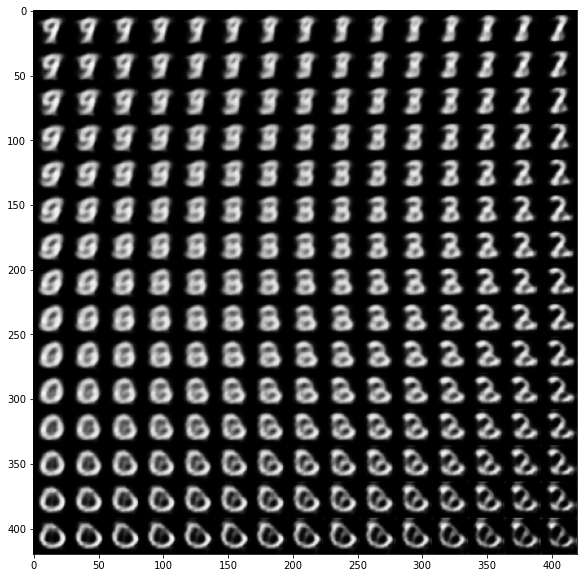

In [11]:
n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size: (i+1)*(digit_size), j*digit_size: (j+1)*digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()